# SDTW on Trainging with Unaligned Dataset
# Setting up Environment

```
$ python -m venv sdtw
$ source sdtw/bin/activate # for linux
$ ./sdtw/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [395]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.core.display as ipd
import pandas as pd
import os
import torch
import libfmp.c5

from lib.nn_losses.soft_dtw_cuda import SoftDTW
from lib.nn_models.nn_dchord import dchord_pipeline
# from lib.helpers.soft_align import soft_align


# Preparing Data for Training

In [396]:
nonchord = False
data_basedir = './res/data'

In [397]:
song_dict = {}

song_dict[0] = ['LetItB', 'r',
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'),
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')]
song_dict[1] = ['HereCo', 'b',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]
song_dict[2] = ['ObLaDi', 'c',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]
song_dict[3] = ['PennyL', 'g',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]
song_dict[4] = ['LetItBFull', 'r', 
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv')]

In [398]:
def compute_X_dict(song_selected, version='STFT', details=True, nonchord=False):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=nonchord)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
#         N = 2048
#         H = 1024
        N = 4096
        H = 2048
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')            # no log compression
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, H=H, version='CQT')                  # no log compression
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')             # no log compression
            
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        ann_dict[s] = libfmp.c5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels
    
song_selected = [0, 1, 2, 3, 4]
#song_selected = [0]
print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT', nonchord=nonchord)

===== Computation of STFT-based chromagrams =====
Processing:  LetItB
Processing:  HereCo
Processing:  ObLaDi
Processing:  PennyL
Processing:  LetItBFull


## Create Dataset + Dataloader

In [399]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, target_length, dataset_params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.target_length = target_length                  # Length of each target sequence
        self.dataset_params = dataset_params                # Parameters for the dataset (e.g., context, stride)

    def __len__(self):
        return self.inputs.size()[0]
    
    def __getitem__(self, idx):
        X = self.inputs.type(torch.FloatTensor)
        y = self.targets.type(torch.FloatTensor)
        return X, y

In [400]:
def colldate_fn(batch):
    # for item in batch:
        # print(item[0].shape, item[1].shape)
    inputs = torch.stack([item[0] for item in batch], dim=0)  # Stack inputs along a new dimension
    
    targets = torch.cat([item[1] for item in batch], dim=0)  # Stack targets along a new dimension

    return inputs, targets

In [401]:
# Not used, kept for reference
class dataset_context(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.context = params['context']
        self.stride = params['stride']
        
    def __len__(self):
        return (self.inputs.size()[1] - self.context) // self.stride
    
    def __getitem__(self, index):
        index *= self.stride
        half_context = self.context // 2
        index += half_context
        X = self.inputs[:, (index - half_context):(index + half_context + 1), :].type(torch.FloatTensor)
        y = torch.unsqueeze(torch.unsqueeze(self.targets[index, :], 0), 1).type(torch.FloatTensor)
        return X, y

In [402]:
def create_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train', mode='soft'):
    all_datasets = []
    segment_length = dataset_params['segment_length']

    #############################
    # If soft_length is defined, it will be used to determine the soft segmentation
    # If not defined, the segmentation will be based on changes in the label sequence
    #   This will cause different soft_lengths for different segments
    ###########################

    soft_length = dataset_params['soft_length']


    assert mode in ['full', 'soft'], "Mode must be either 'full' or 'soft' for dataset creation."

    # Extract voiced frame annotations
    for s in song_indices:
        targets = ann_dict[s][0]
        voiced_frames = np.any(targets !=0, axis=0)
        # print(voiced_frames.shape)
        if voiced_frames.sum() == 0:
            print(f'Warning: No voiced frames found for song {song_dict[s][0]}. Skipping this song.')
            continue
    
        s_idx = np.argmax(voiced_frames)
        e_idx = len(voiced_frames) - np.argmax(voiced_frames[::-1])
        label_seq = targets[:, s_idx:e_idx]

        inputs = data_dict[s].T
        inputs_trimmed = inputs[s_idx:e_idx, :]
        T_total = inputs_trimmed.shape[0]
        num_segments = T_total // segment_length

        for i in range(num_segments):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length
            
            if end_idx > T_total:
                break
            input_seg = inputs_trimmed[start_idx:end_idx, :]
            label_seg = label_seq[:, start_idx:end_idx]
            
            # Perform soft segmentation if required
            if mode == 'soft':
                target_seg = [ label_seg[:, 0] ]
                for idx in range(1, label_seg.shape[1]):
                    if not np.array_equal(label_seg[:, idx], label_seg[:, idx-1]):
                        target_seg.append(label_seg[:, idx])

                if len(target_seg) < soft_length:
                    # If the segment is shorter than the soft length, repeat last element until it reaches the soft length
                    target_seg += [target_seg[-1]] * (soft_length - len(target_seg))

                    # From testing, randomly repeating or repeating the last element gives similar results
                    # Uncomment the following lines to use random repetition instead
                    # # If the segment is shorter than the soft length, repeat random elements until it reaches the soft length
                    # while len(target_seg) < soft_length:
                    #     index = np.random.randint(0, len(target_seg))
                    #     temp = target_seg[index]
                    #     target_seg = target_seg[:index] + [temp] + target_seg[index:]

                else: 
                    # If the segment is longer than the soft length, throw error
                    if len(target_seg) > soft_length:
                        raise ValueError(f'Segment length {len(target_seg)} exceeds soft length {soft_length} for song {song_dict[s][0]}.')

            elif mode == 'full':
                pass
            
            target_seg_len = torch.tensor([len(target_seg)], dtype=torch.int64)
            target_seg = torch.unsqueeze(torch.tensor(target_seg, dtype=torch.float32), 0)
            inputs_tensor = torch.unsqueeze(torch.tensor(input_seg, dtype=torch.float32), 0)

            curr_dataset = dataset(inputs_tensor, target_seg, target_seg_len, dataset_params)
            all_datasets.append(curr_dataset)
                    
        print(f'- {song_dict[s][0]} added to {dataset_description} set. Segments: {num_segments}')
        
    full_dataset = torch.utils.data.ConcatDataset(all_datasets)
    print(f'Total segments created for {dataset_description} dataset: {len(full_dataset)}')
    return full_dataset


In [427]:
train_set_indices = [1, 2, 4]
train_set_params = {'segment_length': 150, 'soft_length': 16}

train_set = create_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train',
                           mode='soft')

print('\n')

val_set_indices = [3]
val_set_params = {'segment_length': 150, 'soft_length': 16}

val_set = create_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val',
                         mode='soft')

- HereCo added to train set. Segments: 13
- ObLaDi added to train set. Segments: 13
- LetItBFull added to train set. Segments: 17
Total segments created for train dataset: 43


- PennyL added to val set. Segments: 12
Total segments created for val dataset: 12


In [428]:
train_loader_params = {'batch_size': 15, 'shuffle': True, 'num_workers': 0, 'collate_fn': colldate_fn}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'Training data loader contains {len(train_loader)} mini batches.')

val_loader_params = {'batch_size': 5, 'shuffle': False, 'num_workers': 0, 'collate_fn': colldate_fn}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'Validation data loader contains {len(val_loader)} mini batches.')

Training data loader contains 3 mini batches.
Validation data loader contains 3 mini batches.


# Train Pipeline

# Initalize dChord Network

In [429]:
# Pipeline config

compression_params = {'gamma_init': 1.0,
                      'trainable': True}

feature_norm_params = {'num_features': 12,
                       'norm': '2', 
                       'threshold': 1e-4}

chord_template_params = {'shared_weights': True, 
                         'initialize_parameters': True, 
                         'normalize_weights': False}

softmax_params = {'tau': 1, 
                  'trainable': False}

In [430]:
model = dchord_pipeline(compression_params=compression_params, 
                        feature_norm_params=feature_norm_params, chord_template_params=chord_template_params,
                        softmax_params=softmax_params)

In [431]:
import torchinfo

torchinfo.summary(model, input_size=(1, 1, 40, 12), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
dchord_pipeline                          [1, 1, 40, 12]       [1, 1, 40, 24]       --                   Partial
├─log_compression: 1-1                   [1, 1, 40, 12]       [1, 1, 40, 12]       1                    True
├─feature_normalization: 1-2             [1, 1, 40, 12]       [1, 1, 40, 12]       --                   --
├─dchord_templates: 1-3                  [1, 1, 40, 12]       [1, 1, 40, 24]       --                   True
│    └─Conv2d: 2-1                       [1, 1, 40, 23]       [1, 2, 40, 12]       24                   True
├─softmax_temperature: 1-4               [1, 1, 40, 24]       [1, 1, 40, 24]       (1)                  False
Total params: 26
Trainable params: 25
Non-trainable params: 1
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

## Specify which parameters to optimize

In [432]:
print('Trainable parameters:\n')

trainable_parameters = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_parameters.append(name)
        print(f"'{name}'") 

Trainable parameters:

'log_compression.log_gamma'
'chord_template_params.filter.weight'


Optimization mode $\in \{0, 1, 2 \}$:  
- 0: optimize all trainable parameters 
- 1: optimize **all** trainable parameters **except** the ones specified in `frozen_parameters`
- 2: optimize **only** the parameters specified in `trained_parameters`

(`frozen_parameters` and `trained_parameters` must be lists of strings and a subset of the trainable parameters shown above)

For no optimization at all: set training epochs to zero.

In [433]:
optimization_mode = 0

if optimization_mode == 1:
    frozen_parameters = []           

if optimization_mode == 2:
    trained_parameters = []

In [434]:
if optimization_mode == 0:
    parameters_to_optimize = model.parameters()
    
elif optimization_mode == 1:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if not name in frozen_parameters:
            parameters_to_optimize.append(param)
            
elif optimization_mode == 2:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if name in trained_parameters:
            parameters_to_optimize.append(param)

### Set Optimizer, Training Parameters and Loss

In [435]:
optim_params = {'lr': 0.1, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(parameters_to_optimize, **optim_params)

In [ ]:
training_params = {'device': 'cpu', 'max_epochs': 200}
# training_params = {'device': 'cuda:0', 'max_epochs': 25}

# weights for fighting class imbalance major / minor in training dataset
weight = torch.cat((torch.ones(12), torch.ones(12)))           
# weight = torch.cat((torch.ones(12), 19*torch.ones(12)))

crit = torch.nn.NLLLoss(weight=weight, reduction='mean').to(training_params['device'])  # Categorical CE without log

In [437]:
normalize = False

crit = SoftDTW(use_cuda=False, gamma=0.1, dist_func=None, normalize=normalize)

### Network Training - Weakly Aligned Dataset

Train the model. After each training epoch (one iteration over the train dataloader), evaluate performanceon the validation set. We use a variable `best_model` that contains the current best model (the model with the overall lowest validation loss). At the end of the training, the `best_model` ist used for evaluation.

In [438]:
# reduced version of libdl.training.trainer

from copy import deepcopy

model_pipeline = model.to(training_params['device'])

# for always keeping the best model
best_model = deepcopy(model_pipeline)
best_val_loss = None
best_epoch = None

train_losses = []
val_losses = []

for epoch in range(training_params['max_epochs']):
    # set model to training mode; relevant, e.g., for BatchNorm, Dropout (does not change anything for our model here)
    model_pipeline.train()
    
    with torch.enable_grad():
        accum_loss, n_batches = 0, 0
        for X, y in train_loader:
            X, y = X.to(training_params['device']), y.to(training_params['device'])

            # get model prediction
            y_pred = model_pipeline(X)
            # Remove channel dimension
            y_pred = torch.squeeze(y_pred, 1)  # remove the channel dimension
            y = torch.squeeze(y, 1)  # remove the channel dimension
            
            loss = crit(y_pred, y )
            
            # backpropagation + optimization
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            accum_loss += loss.mean().item()
            n_batches += 1


    # set model to evaluation mode
    model_pipeline.eval()
    
    with torch.no_grad():    
        accum_loss_val, n_batches_val = 0, 0
        for X_val, y_val in val_loader:
            X_val, y_val= X_val.to(training_params['device']), y_val.to(training_params['device'])

            y_pred_val = model_pipeline(X_val)
            
            # Remove channel dimension
            y_pred_val = torch.squeeze(y_pred_val, 1)  # remove the channel
            y_val = torch.squeeze(y_val, 1)

            # get loss value
            loss_val = crit(y_pred_val, y_val)
            accum_loss_val += loss_val.mean().item()
            n_batches_val += 1        

    train_loss = accum_loss / n_batches
    val_loss = accum_loss_val / n_batches_val
    print(f'Finished epoch {epoch}. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_pipeline)
        best_epoch = epoch
        print('    ...saved model')
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
model_pipeline = deepcopy(best_model)
print(f'\nRestored model from epoch {best_epoch}.')

Finished epoch 0. Train Loss: 134.0758, Val Loss: 129.7338
    ...saved model
Finished epoch 1. Train Loss: 129.4063, Val Loss: 127.4573
    ...saved model
Finished epoch 2. Train Loss: 126.7352, Val Loss: 124.9383
    ...saved model
Finished epoch 3. Train Loss: 123.7861, Val Loss: 121.8182
    ...saved model
Finished epoch 4. Train Loss: 120.2167, Val Loss: 118.3231
    ...saved model
Finished epoch 5. Train Loss: 116.1821, Val Loss: 114.5485
    ...saved model
Finished epoch 6. Train Loss: 112.0984, Val Loss: 110.6490
    ...saved model
Finished epoch 7. Train Loss: 108.7708, Val Loss: 106.7523
    ...saved model
Finished epoch 8. Train Loss: 105.3108, Val Loss: 103.1059
    ...saved model
Finished epoch 9. Train Loss: 101.7746, Val Loss: 99.7996
    ...saved model
Finished epoch 10. Train Loss: 99.1679, Val Loss: 96.9128
    ...saved model
Finished epoch 11. Train Loss: 96.7939, Val Loss: 94.4158
    ...saved model
Finished epoch 12. Train Loss: 94.5910, Val Loss: 92.2484
    ...sa

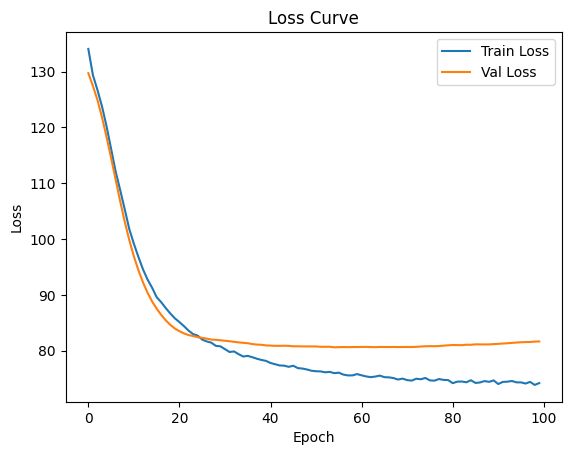

In [439]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

In [440]:
print(X.shape)
print(y.shape)

torch.Size([13, 1, 150, 12])
torch.Size([13, 16, 24])


# Investigate Model

In [441]:
import matplotlib
# Class for visualizing chord templates with zero-centered diverging colormap

# Example of making your own norm.  Also see matplotlib.colors.
# From Joe Kington: This one gives two different linear ramps:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



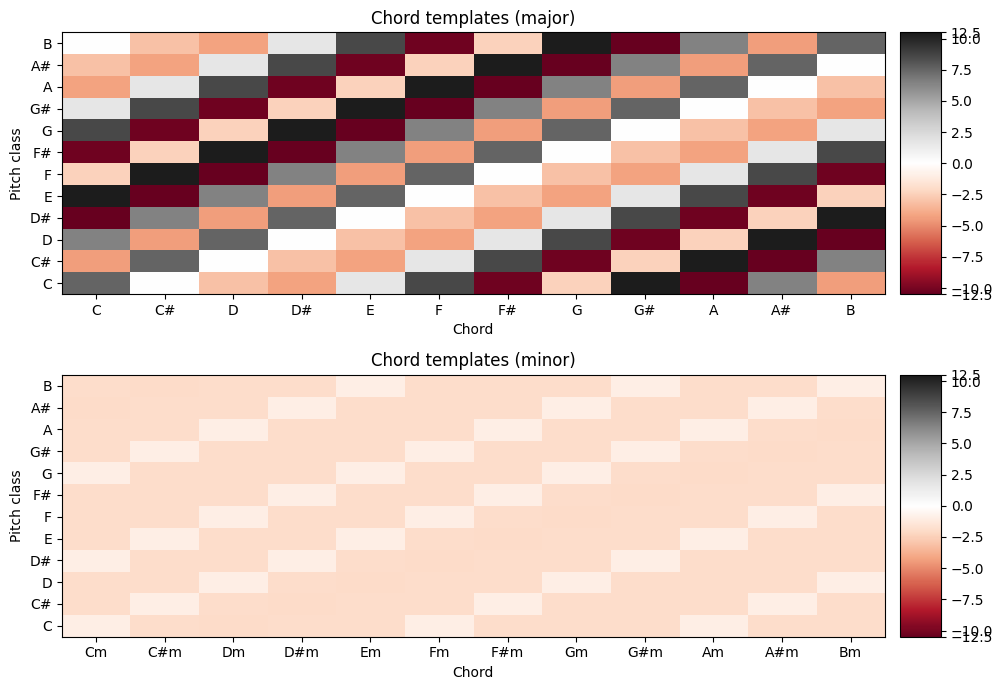

In [442]:
chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
ext_minor = 'm'
chord_labels_maj = chroma_labels
chord_labels_min = [s + ext_minor for s in chroma_labels]
chord_labels = chord_labels_maj + chord_labels_min

# read weights from layer
weights = model_pipeline.chord_template_params.filter.weight.to('cpu').detach()
weights = np.squeeze(weights)

templates_maj = np.zeros((12,12))
templates_min = np.zeros((12,12))

if weights.shape[0] == 2:
    for n in range(12):           # shared weights -> templates are only shifted versions of each other
        templates_maj[:, n] = np.roll(weights[0], n)
        templates_min[:, n] = np.roll(weights[1], n)
    
elif weights.shape[0] == 24:
    templates_maj = np.asarray(weights[:12, :]).T
    templates_min = np.asarray(weights[12:, :]).T
    

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 7))
    
# determine appropriate colormap for plots
if np.min([templates_maj, templates_min]) < 0:
    abs_max = np.abs([templates_maj, templates_min]).max()
    plot_parameters = {'cmap': 'RdGy', 'norm': MidpointNormalize(vmin=-abs_max, vmax=abs_max, midpoint=0, clip=False)}
else:
    plot_parameters = {'cmap': 'gray_r'}
    
# plot major chord templates
libfmp.b.plot_matrix(templates_maj, ax=[ax[0, 0], ax[0, 1]], 
                     title='Chord templates (major)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[0, 0].set_xticks(np.arange(12))
ax[0, 0].set_xticklabels(chord_labels_maj)
ax[0, 0].set_yticks(np.arange(12))
ax[0, 0].set_yticklabels(chroma_labels)

# plot minor chord templates
libfmp.b.plot_matrix(templates_min, ax=[ax[1, 0], ax[1, 1]], 
                     title='Chord templates (minor)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[1, 0].set_xticks(np.arange(12))
ax[1, 0].set_xticklabels(chord_labels_min)
ax[1, 0].set_yticks(np.arange(12))
ax[1, 0].set_yticklabels(chroma_labels)

plt.tight_layout()


## Caveat
The current network attempts to train how to predict a single frame with temporal context. What really happens is that it take out a frame, with +-25 for context; then predict which chord corresponds to that frame.

For misalignment this is not neccessary, as we would simple load the whole sequence with multiple frames, then align it implicitly and output the whole sequence.

`TODO List`

- ~~refactor by remove temporal smoothness process.~~
- ~~fix dimension so that predict and target fits the loss~~
- ~~fix soft_align so that it produce one-hot-encoding~~
- allow stacking batch (error occured when stacking different dim)
- try plot path and final weight
- get results from strongly aligned for comparison
- refactor functions

`IDEAL`: parse L frames `(B,1,L,12)` and predict corresponding sequence `(B,1,L,24)`

Then for testing, we can effectively parse the input sequence, predict then plot it.